# Pilatus on a goniometer at ID28

Nguyen Thanh Tra who was post-doc at ESRF-ID28 enquired about a potential bug in pyFAI in October 2016: he calibrated 3 images taken with a Pilatus-1M detector at various detector angles: 0, 17 and 45 degrees. 
While everything looked correct, in first approximation, one peak did not overlap properly with itself depending on the detector angle. This peak correspond to the peak in the angle of the detector, at 23.6° ...

This notebook will guide you through the calibration of the goniometer setup.

Let's first retrieve the images and initialize the environment:

In [1]:
%matplotlib inline
# use `widget` instead of `inline` for better user-exeperience. `inline` allows to store plots into notebooks.

In [2]:
import os, sys, time
start_time = time.perf_counter()
print(sys.version)

3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]


In [3]:
import numpy
import fabio, pyFAI
print(f"Using pyFAI version: {pyFAI.version}")
from os.path import basename
from pyFAI.gui import jupyter
from pyFAI.calibrant import get_calibrant
from silx.resources import ExternalResources
from scipy.interpolate import interp1d
from scipy.optimize import bisect
from matplotlib.pyplot import subplots
from matplotlib.lines import Line2D
downloader = ExternalResources("thick", "http://www.silx.org/pub/pyFAI/testimages")
all_files = downloader.getdir("gonio_ID28.tar.bz2")
for afile in all_files:
    print(basename(afile))


Using pyFAI version: 2025.1.0-dev0
gonio_ID28
det130_g45_0001p.npt
det130_g0_0001p.cbf
det130_g17_0001p.npt
det130_g0_0001p.npt
det130_g45_0001p.cbf
det130_g17_0001p.cbf


There are 3 images stored as CBF files and the associated control points as npt files. 

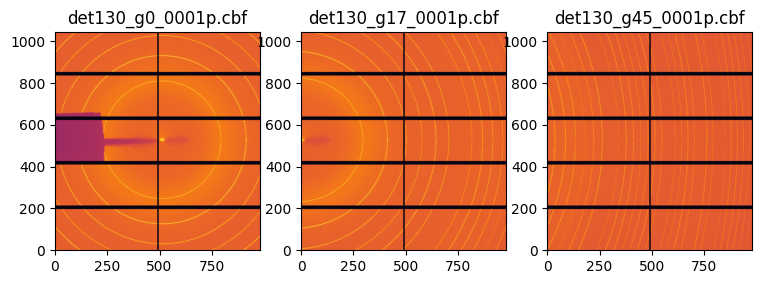

In [4]:
images = [i for i in all_files if i.endswith("cbf")]
images.sort()
mask = None
fig, ax = subplots(1,3, figsize=(9,3))
for i, cbf in enumerate(images):
    fimg = fabio.open(cbf)
    jupyter.display(fimg.data, label=basename(cbf), ax=ax[i])
    if mask is None:
        mask = fimg.data<0
    else:
        mask |= fimg.data<0

numpy.save("mask.npy", mask)

To be able to calibrate the detector position, the calibrant used is LaB6 and the wavelength was 0.69681e-10m 

In [5]:
wavelength=0.6968e-10
calibrant = get_calibrant("LaB6")
calibrant.wavelength = wavelength
print(calibrant)

detector =  pyFAI.detector_factory("Pilatus1M")

LaB6 Calibrant with 120 reflections at wavelength 6.968e-11


In [6]:
# Define the function that extracts the angle from the filename:

def get_angle(basename):
    """Takes the basename (like det130_g45_0001.cbf ) and returns the angle of the detector"""
    return float(os.path.basename((basename.split("_")[-2][1:])))

for afile in images:
    print('filename', afile, "angle:",get_angle(afile))

filename /tmp/thick_testdata_kieffer/gonio_ID28.tar.bz2__content/gonio_ID28/det130_g0_0001p.cbf angle: 0.0
filename /tmp/thick_testdata_kieffer/gonio_ID28.tar.bz2__content/gonio_ID28/det130_g17_0001p.cbf angle: 17.0
filename /tmp/thick_testdata_kieffer/gonio_ID28.tar.bz2__content/gonio_ID28/det130_g45_0001p.cbf angle: 45.0


In [7]:
#Define the transformation of the geometry as function of the goniometrer position. 
# by default scale1 = pi/180 (convert deg to rad) and scale2 = 0.

from pyFAI.goniometer import GeometryTransformation, GoniometerRefinement, Goniometer

goniotrans2d = GeometryTransformation(param_names = ["dist", "poni1", "poni2",
                                                    "rot1", "rot2",
                                                     "scale1", "scale2"],
                                     dist_expr="dist",
                                     poni1_expr="poni1",
                                     poni2_expr="poni2",
                                     rot1_expr="scale1 * pos + rot1",
                                     rot2_expr="scale2 * pos + rot2",
                                     rot3_expr="0.0")

In [8]:
epsilon = numpy.finfo(numpy.float32).eps
#Definition of the parameters start values and the bounds
param = {"dist":0.30,
         "poni1":0.08,
         "poni2":0.08,
         "rot1":0,
         "rot2":0,
         "scale1": numpy.pi/180., # rot2 is in radians, while the motor position is in degrees
         "scale2": 0
        }

#Defines the bounds for some variables. We start with very strict bounds
bounds = {"dist": (0.25, 0.31),
          "poni1": (0.07, 0.1),
          "poni2": (0.07, 0.1),
          "rot1": (-0.01, 0.01),
          "rot2": (-0.01, 0.01),
          "scale1": (numpy.pi/180.-epsilon, numpy.pi/180.+epsilon), #strict bounds on the scale: we expect the gonio to be precise
          "scale2": (-epsilon, +epsilon) #strictly bound to 0
         }

In [9]:
gonioref2d = GoniometerRefinement(param, #initial guess
                                  bounds=bounds,
                                  pos_function=get_angle,
                                  trans_function=goniotrans2d,
                                  detector=detector, 
                                  wavelength=wavelength)
print("Empty goniometer refinement object:")
print(gonioref2d)

Empty goniometer refinement object:
GoniometerRefinement with 0 geometries labeled: .


In [10]:
# Populate with the images and the control points
for fn in images:
    base = os.path.splitext(fn)[0]
    bname = os.path.basename(base)
    fimg = fabio.open(fn)
    sg =gonioref2d.new_geometry(bname, image=fimg.data, metadata=bname, 
                                control_points=base+".npt",
                                calibrant=calibrant)
    print(sg.label, "Angle:", sg.get_position())


print("Filled refinement object:")
print(gonioref2d)

det130_g0_0001p Angle: 0.0
det130_g17_0001p Angle: 17.0
det130_g45_0001p Angle: 45.0
Filled refinement object:
GoniometerRefinement with 3 geometries labeled: det130_g0_0001p, det130_g17_0001p, det130_g45_0001p.


In [11]:
# Initial refinement of the goniometer model with 5 dof

gonioref2d.refine2()


Cost function before refinement: 0.0007718180621418162
[0.3        0.08       0.08       0.         0.         0.01745329
 0.        ]
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 4.3654701940099663e-08
       x: [ 2.846e-01  8.940e-02  8.893e-02  4.439e-03  2.991e-03
            1.745e-02 -1.192e-07]
     nit: 21
     jac: [ 8.654e-09  8.906e-08  3.361e-07 -9.269e-08  3.545e-08
           -3.498e-03  9.705e-04]
    nfev: 170
    njev: 21
Cost function after refinement: 4.3654701940099663e-08
GonioParam(dist=np.float64(0.2845623301495525), poni1=np.float64(0.08939754494173414), poni2=np.float64(0.08893365504236604), rot1=np.float64(0.004439098389015228), rot2=np.float64(0.0029909802008492446), scale1=np.float64(0.01745341159403324), scale2=np.float64(-1.1920928955078125e-07))
maxdelta on: dist (0) 0.3 --> 0.2845623301495525


array([ 2.84562330e-01,  8.93975449e-02,  8.89336550e-02,  4.43909839e-03,
        2.99098020e-03,  1.74534116e-02, -1.19209290e-07])

In [12]:
# Remove constrains on the refinement:
gonioref2d.bounds=None
gonioref2d.refine2()


Cost function before refinement: 4.3654701940099663e-08
[ 2.84562330e-01  8.93975449e-02  8.89336550e-02  4.43909839e-03
  2.99098020e-03  1.74534116e-02 -1.19209290e-07]
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.8722341765613295e-08
       x: [ 2.845e-01  8.865e-02  8.931e-02  5.490e-03  5.546e-03
            1.746e-02 -2.098e-05]
     nit: 13
     jac: [ 6.918e-09 -4.780e-08 -2.974e-07 -4.291e-07  2.077e-07
            1.492e-06  2.223e-07]
    nfev: 111
    njev: 13
Cost function after refinement: 1.8722341765613295e-08
GonioParam(dist=np.float64(0.284547624738513), poni1=np.float64(0.08865488983383199), poni2=np.float64(0.08930783218680288), rot1=np.float64(0.005489878936488505), rot2=np.float64(0.005546132487657844), scale1=np.float64(0.0174619292214258), scale2=np.float64(-2.0975514545368076e-05))
maxdelta on: rot2 (4) 0.0029909802008492446 --> 0.005546132487657844


array([ 2.84547625e-01,  8.86548898e-02,  8.93078322e-02,  5.48987894e-03,
        5.54613249e-03,  1.74619292e-02, -2.09755145e-05])

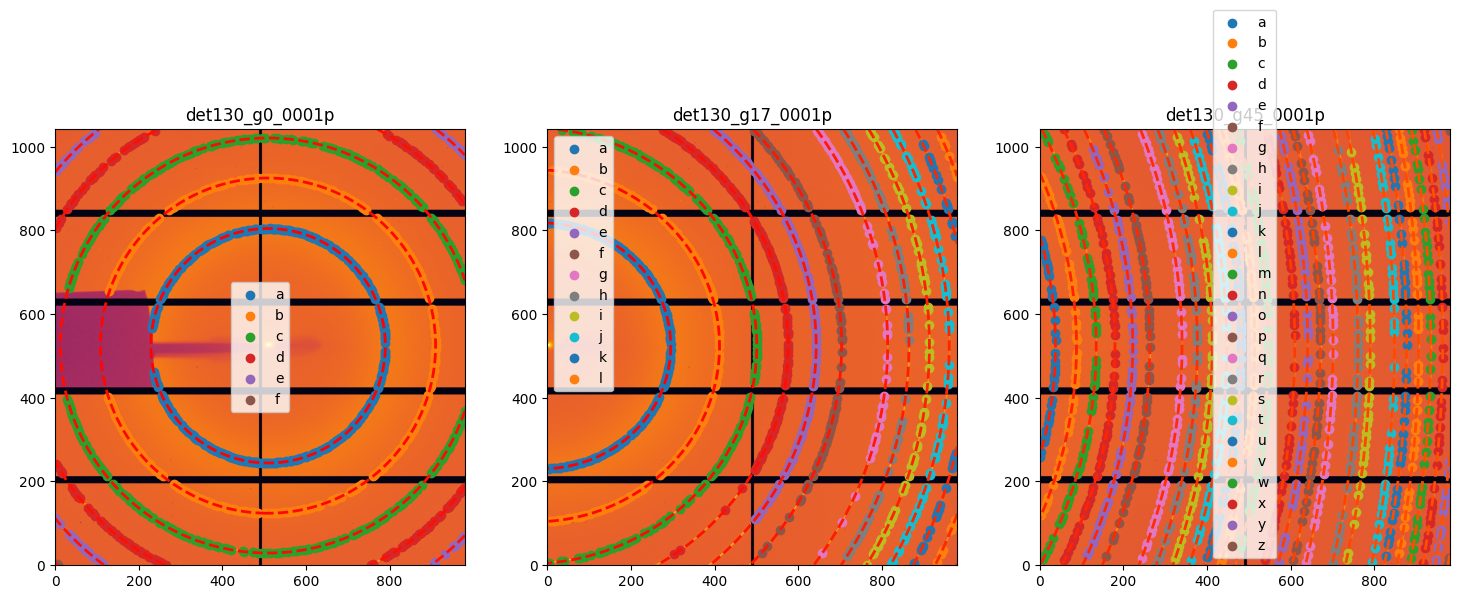

In [13]:
# Check the calibration on all 3 images

fig, ax = subplots(1, 3, figsize=(18, 6) )
for idx,lbl in enumerate(gonioref2d.single_geometries):
    sg = gonioref2d.single_geometries[lbl]
    if sg.control_points.get_labels():
        sg.geometry_refinement.set_param(gonioref2d.get_ai(sg.get_position()).param)
    a=jupyter.display(sg=sg, ax=ax[idx])

MultiGeometry integrator with 3 geometries on (0, 63) radial range ((2th_deg, chi_deg)) and (-180, 180) azimuthal range (deg)


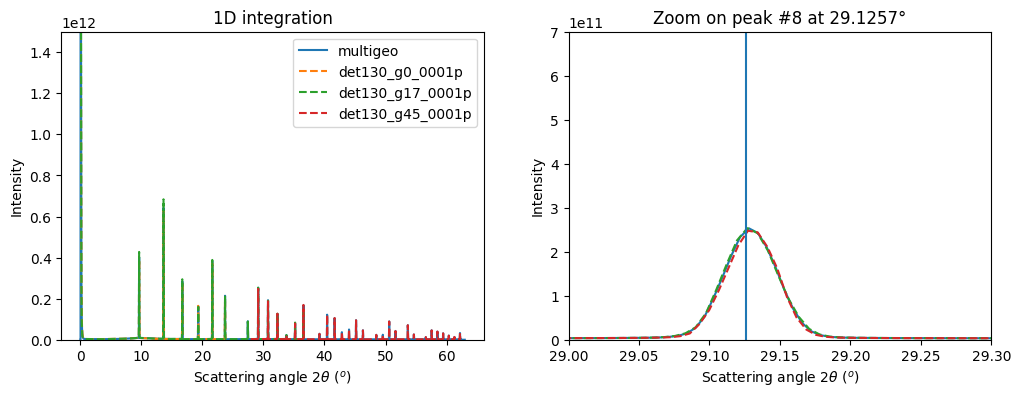

In [14]:
#Create a MultiGeometry integrator from the refined geometry:

angles = []
images = []
for sg in gonioref2d.single_geometries.values():
    angles.append(sg.get_position())
    images.append(sg.image)

multigeo = gonioref2d.get_mg(angles)
multigeo.radial_range=(0, 63)
print(multigeo)
# Integrate the whole set of images in a single run:

res_mg = multigeo.integrate1d(images, 10000)
fig, ax = subplots(1, 2, figsize=(12,4))
ax0 = jupyter.plot1d(res_mg, label="multigeo", ax=ax[0])
ax1 = jupyter.plot1d(res_mg, label="multigeo", ax=ax[1])

# Let's focus on the inner most ring on the image taken at 45°:
for lbl, sg in gonioref2d.single_geometries.items():
    ai = gonioref2d.get_ai(sg.get_position())
    img = sg.image * ai.dist * ai.dist / ai.pixel1 / ai.pixel2
    res = ai.integrate1d(img, 5000, unit="2th_deg", method="splitpixel")
    ax0.plot(*res, "--", label=lbl)
    ax1.plot(*res, "--", label=lbl)
ax1.set_xlim(29,29.3)
ax0.set_ylim(0, 1.5e12)
ax1.set_ylim(0, 7e11)
p8tth = numpy.rad2deg(calibrant.get_2th()[7])
ax1.set_title("Zoom on peak #8 at %.4f°"%p8tth)
l = Line2D([p8tth, p8tth], [0, 2e12])
ax1.add_line(l)
ax0.legend()
ax1.legend().remove()
pass

On all three imges, the rings on the outer side of the detector are shifted in compatison with the average signal comming from the other two images. 
This phenomenon could be related to volumetric absorption of the photon in the thickness of the detector.

To be able to investigate this phenomenon further, the goniometer geometry is saved in a JSON file:

In [15]:
gonioref2d.save("id28.json")

with open("id28.json") as f:
    print(f.read())

{
  "content": "Goniometer calibration v2",
  "detector": "Pilatus 1M",
  "detector_config": {
    "orientation": 3
  },
  "wavelength": 6.968e-11,
  "param": [
    0.284547624738513,
    0.08865488983383199,
    0.08930783218680288,
    0.005489878936488505,
    0.005546132487657844,
    0.0174619292214258,
    -2.0975514545368076e-05
  ],
  "param_names": [
    "dist",
    "poni1",
    "poni2",
    "rot1",
    "rot2",
    "scale1",
    "scale2"
  ],
  "pos_names": [
    "pos"
  ],
  "trans_function": {
    "content": "GeometryTransformation",
    "param_names": [
      "dist",
      "poni1",
      "poni2",
      "rot1",
      "rot2",
      "scale1",
      "scale2"
    ],
    "pos_names": [
      "pos"
    ],
    "dist_expr": "dist",
    "poni1_expr": "poni1",
    "poni2_expr": "poni2",
    "rot1_expr": "scale1 * pos + rot1",
    "rot2_expr": "scale2 * pos + rot2",
    "rot3_expr": "0.0",
    "constants": {
      "pi": 3.141592653589793
    }
  }
}


## Peak profile

Let's plot the full-width at half maximum for every peak in the different intergated profiles:

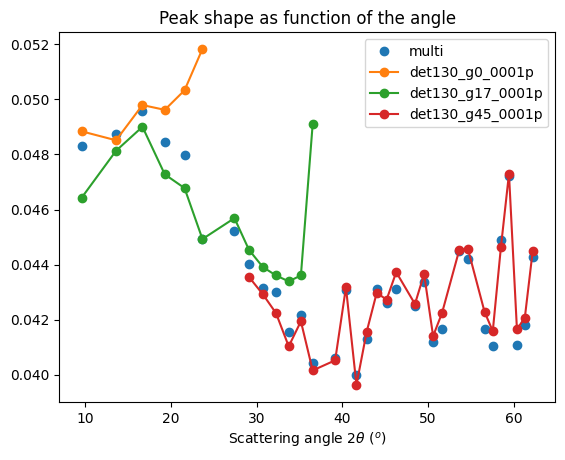

In [16]:
#Peak profile

def calc_fwhm(integrate_result, calibrant):
    "calculate the tth position and FWHM for each peak"
    delta = integrate_result.intensity[1:] - integrate_result.intensity[:-1]
    maxima = numpy.where(numpy.logical_and(delta[:-1]>0, delta[1:]<0))[0]
    minima = numpy.where(numpy.logical_and(delta[:-1]<0, delta[1:]>0))[0]
    maxima += 1
    minima += 1
    tth = []
    FWHM = []
    for tth_rad in calibrant.get_2th():
        tth_deg = tth_rad*integrate_result.unit.scale
        if (tth_deg<=integrate_result.radial[0]) or (tth_deg>=integrate_result.radial[-1]):
            continue
        idx_theo = abs(integrate_result.radial-tth_deg).argmin()
        id0_max = abs(maxima-idx_theo).argmin()
        id0_min = abs(minima-idx_theo).argmin()
        I_max = integrate_result.intensity[maxima[id0_max]]
        I_min = integrate_result.intensity[minima[id0_min]]
        tth_maxi = integrate_result.radial[maxima[id0_max]]
        I_thres = (I_max + I_min)/2.0
        if minima[id0_min]>maxima[id0_max]:
            if id0_min == 0:
                min_lo = integrate_result.radial[0]
            else:
                min_lo = integrate_result.radial[minima[id0_min-1]]
            min_hi = integrate_result.radial[minima[id0_min]]
        else:
            if id0_min == len(minima) -1:
                min_hi = integrate_result.radial[-1]
            else:
                min_hi = integrate_result.radial[minima[id0_min+1]]
            min_lo = integrate_result.radial[minima[id0_min]]
            
        f = interp1d(integrate_result.radial, integrate_result.intensity-I_thres)
        tth_lo = bisect(f, min_lo, tth_maxi)
        tth_hi = bisect(f, tth_maxi, min_hi)
        FWHM.append(tth_hi-tth_lo)
        tth.append(tth_deg)
    return tth, FWHM
    
fig, ax = subplots()
ax.plot(*calc_fwhm(res_mg, calibrant), "o", label="multi")
for lbl, sg in gonioref2d.single_geometries.items():
    ai = gonioref2d.get_ai(sg.get_position())
    img = sg.image * ai.dist * ai.dist / ai.pixel1 / ai.pixel2
    res = ai.integrate1d(img, 5000, unit="2th_deg", method="splitpixel")
    t,w = calc_fwhm(res, calibrant=calibrant)
    ax.plot(t, w,"-o", label=lbl)
ax.set_title("Peak shape as function of the angle")
ax.set_xlabel(res_mg.unit.label)
ax.legend()
pass

## Conclusion:
Can the FWHM and peak position be corrected using raytracing and deconvolution ?

In [17]:
print(f"Total execution time: {time.perf_counter()-start_time:.3f} s")

Total execution time: 8.319 s
